# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [34]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Define global parameters

In [35]:
##region of interest
# offset in pixels from the vertical center of the image (Y) for the region of interest
VERTICAL_OFFSET = 50
VERT_BOTTOM_OFFSET = 0
HORZ_LEFT_OFFSET = 50
HORZ_RIGHT_OFFSET = 50
# offsets from the horizontal certer of the image for the region of interest
LEFT_VERTEX_OFFSET = 10
RIGHT_VERTEX_OFFSET = 15
# tolerance for lines inclination
MIN_INCLINATION = 0.5
# hough params
HOUGH_VOTES = 10
HOUGH_MINLEN = 10
HOUGH_MAXGAP = 4
# gaussian blur
GAUSSIAN_KERNEL = 5
# canny transform params
CANNY_LOW_THRESHOLD = 50
CANNY_HIGH_THRESHOLD = 150

## Helper Functions

In [36]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region_img of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    global last_m_left, last_m_right, last_b_left, last_b_right

    if lines is None:
        return

    #uncomment following code to draw the bare lines discovered by hough transform
    # for line in lines:
    #     for x1, y1, x2, y2 in line:
    #         cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness)
    # return

    #interpolate a single line for each road lane
    right_line = []
    left_line = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            # print("x1: ",x1,", y1: ",y1,", x2: ",x2,", y2: ",y2)
            m = (y2 - y1) / (x2 - x1)
            if abs(m) < MIN_INCLINATION or np.isinf(m):
                continue
            b = -m * x1 + y1
            if m < 0:
                left_line.append((m, b))
            else:
                right_line.append((m, b))

    # for params in left_line:
    #     print("m: ",params[0]," b: ",params[1])

    if len(left_line) > 0 and len(right_line) > 0:
        last_m_right, last_b_right = (
            sum(x[0] for x in right_line) / len(right_line), sum(x[1] for x in right_line) / len(right_line))
        last_m_left, last_b_left = (
            sum(x[0] for x in left_line) / len(left_line), sum(x[1] for x in left_line) / len(left_line))

    # print("left line m: ",left_line_avg_m," left line b: ",left_line_avg_b)
    # print("right line m: ",right_line_avg_m," right line b: ",right_line_avg_b)

    # left line
    newy1 = int(img.shape[0] / 2 + VERTICAL_OFFSET)
    newx1 = int((newy1 - last_b_left) / last_m_left)
    newy2 = img.shape[0]
    newx2 = int((newy2 - last_b_left) / last_m_left)
    cv2.line(img, (newx1, newy1), (newx2, newy2), color, 10)
    # right line
    newy1 = int(img.shape[0] / 2 + VERTICAL_OFFSET)
    newx1 = int((newy1 - last_b_right) / last_m_right)
    newy2 = img.shape[0]
    newx2 = int((newy2 - last_b_right) / last_m_right)
    cv2.line(img, (newx1, newy1), (newx2, newy2), color, 10)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



In [37]:
def pipeline(img):
    ysize = img.shape[0]
    xsize = img.shape[1]
    #step 1: convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # plt.imshow(gray_img)
    # plt.show()

    #step 2: blur image
    blur_img = gaussian_blur(gray_img, GAUSSIAN_KERNEL)
    # plt.imshow(blur_img)
    # plt.show()

    #step 3: detect edges
    canny_img = canny(blur_img, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    # plt.imshow(canny_img)
    # plt.show()

    #step 4: mask the region of interest
    medium_height = int(ysize / 2 + VERTICAL_OFFSET)
    region_img = region_of_interest(canny_img, np.array([[
        (HORZ_LEFT_OFFSET, ysize - VERT_BOTTOM_OFFSET),
        (int(xsize / 2 - LEFT_VERTEX_OFFSET), medium_height),
        (int(xsize / 2 + RIGHT_VERTEX_OFFSET), medium_height),
        (xsize - HORZ_RIGHT_OFFSET, ysize - VERT_BOTTOM_OFFSET)
    ]]))
    # plt.imshow(region_img)
    # plt.show()

    #step 5: discover lines using hough transform and draw over the original image
    hough_img = hough_lines(region_img, 1, np.pi / 360, HOUGH_VOTES, HOUGH_MINLEN, HOUGH_MAXGAP)
    lines_edges = weighted_img(hough_img, img, 0.8, 1, 0)
    return lines_edges

def process_image(image):
    result = pipeline(image)
    return result

## Test on Images

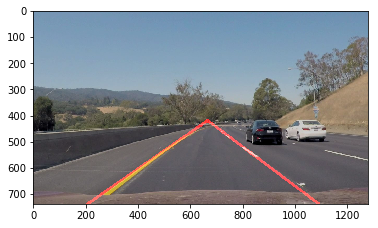

In [38]:
import os
test_images = os.listdir("test_images/")

img = process_image(plt.imread("test_images/"+test_images[0]))
plt.imshow(img)

## Test on Videos

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### video 1: white right line

In [40]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 69.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 3.58 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### video 2: yellow left line

In [42]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:09<00:00, 70.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 10 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### video 3: challenge video

In [44]:
challenge_output = 'extra.mp4'
RIGHT_VERTEX_OFFSET = 45
VERTICAL_OFFSET = 60
VERT_BOTTOM_OFFSET = 100
MIN_INCLINATION = 0.6
CANNY_LOW_THRESHOLD = 30
CANNY_HIGH_THRESHOLD = 140
HOUGH_MINLEN = 16
HOUGH_VOTES = 20
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:06<00:00, 36.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 7.61 s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### video 4: own video

In [46]:
VERTICAL_OFFSET = 50
RIGHT_VERTEX_OFFSET = 90
LEFT_VERTEX_OFFSET = 50
VERT_BOTTOM_OFFSET = 120
HORZ_RIGHT_OFFSET = 130
HORZ_LEFT_OFFSET = 670
MIN_INCLINATION = 0.52
CANNY_LOW_THRESHOLD = 60
CANNY_HIGH_THRESHOLD = 160
HOUGH_MINLEN = 16
HOUGH_VOTES = 10
own_output = 'own1.mp4'
clip1 = VideoFileClip("20170219_071145.mp4")
own_clip = clip1.fl_image(process_image)
%time own_clip.write_videofile(own_output, audio=False)

[MoviePy] >>>> Building video own1.mp4
[MoviePy] Writing video own1.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 882/882 [00:42<00:00, 20.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: own1.mp4 

Wall time: 43.3 s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(own_output))